# __Smart weather station with Tensorflow Lite Micro and Raspberry Pico__

$$ $$
$$ Author: NhutNguyen $$
$$ Author-email: nhut0550.1109@gmail.com $$
$$ Author-github: github.com/mnhut0550 $$
$$ $$

### This examples is using Ho Chi Minh City weather history data from __visualcrossing.com__
### from 01.01.2015 to 02.10.2022
### __8-bit version (Quantization)__
### This examples is using Tensorflow 2.5.0 on CPU

In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import os
import pandas as pd

In [2]:
##SETUP FIGURES SIZE

mpl.rcParams['figure.figsize'] = (24,10)
mpl.rcParams['axes.grid'] = False

In [3]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epoch = range(len(loss))

    plt.figure()
    plt.plot(epoch, loss, 'b', label='Training loss')
    plt.plot(epoch, val_loss, 'g', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

In [4]:
def multi_step_plot(history, true_future, prediction, df_columns, step=1):
    plt.figure(figsize=(12, 6))
    num_in = list(range(-len(history),0)) ### time steps
    num_out = len(true_future)

    num_labels = history.shape[-1] if len(history.shape) == 2 else 1
    ### for new_df, we need to remove 3 first columns
    df_columns = df_columns[3:]
    num_labels = num_labels - 3
    history = history[:, 3:]

    if num_labels != len(df_columns):
        raise ValueError('Number of data columns does not match.')

    figure, ax = plt.subplots(nrows=num_labels, ncols=1)

    for i in range(num_labels):
        ax[i].title.set_text(df_columns[i])

        ax[i].plot(num_in, np.array(history[:,i]), label='History')
        ax[i].plot(np.arange(num_out)/step, np.array(true_future[:,i]),label='True Future')

        ax[i].plot(np.arange(num_out)/step, np.array(prediction[:,i]),label='Predicted Future')
        ax[i].legend(loc='upper left')
    plt.show()

In [5]:
df = pd.read_csv('hochiminh_2015-01-01_to_2022-10-02.csv')

In [6]:
features_examples_column = ['temp','humidity']#,'feelslike']

features = df[features_examples_column]
# features.index = df['datetime']
features.head()

,temp,humidity
0,24.6,71.06
1,24.5,77.06
2,24.0,78.35
3,24.0,78.35
4,24.0,81.94


array([<AxesSubplot: >, <AxesSubplot: >], dtype=object)

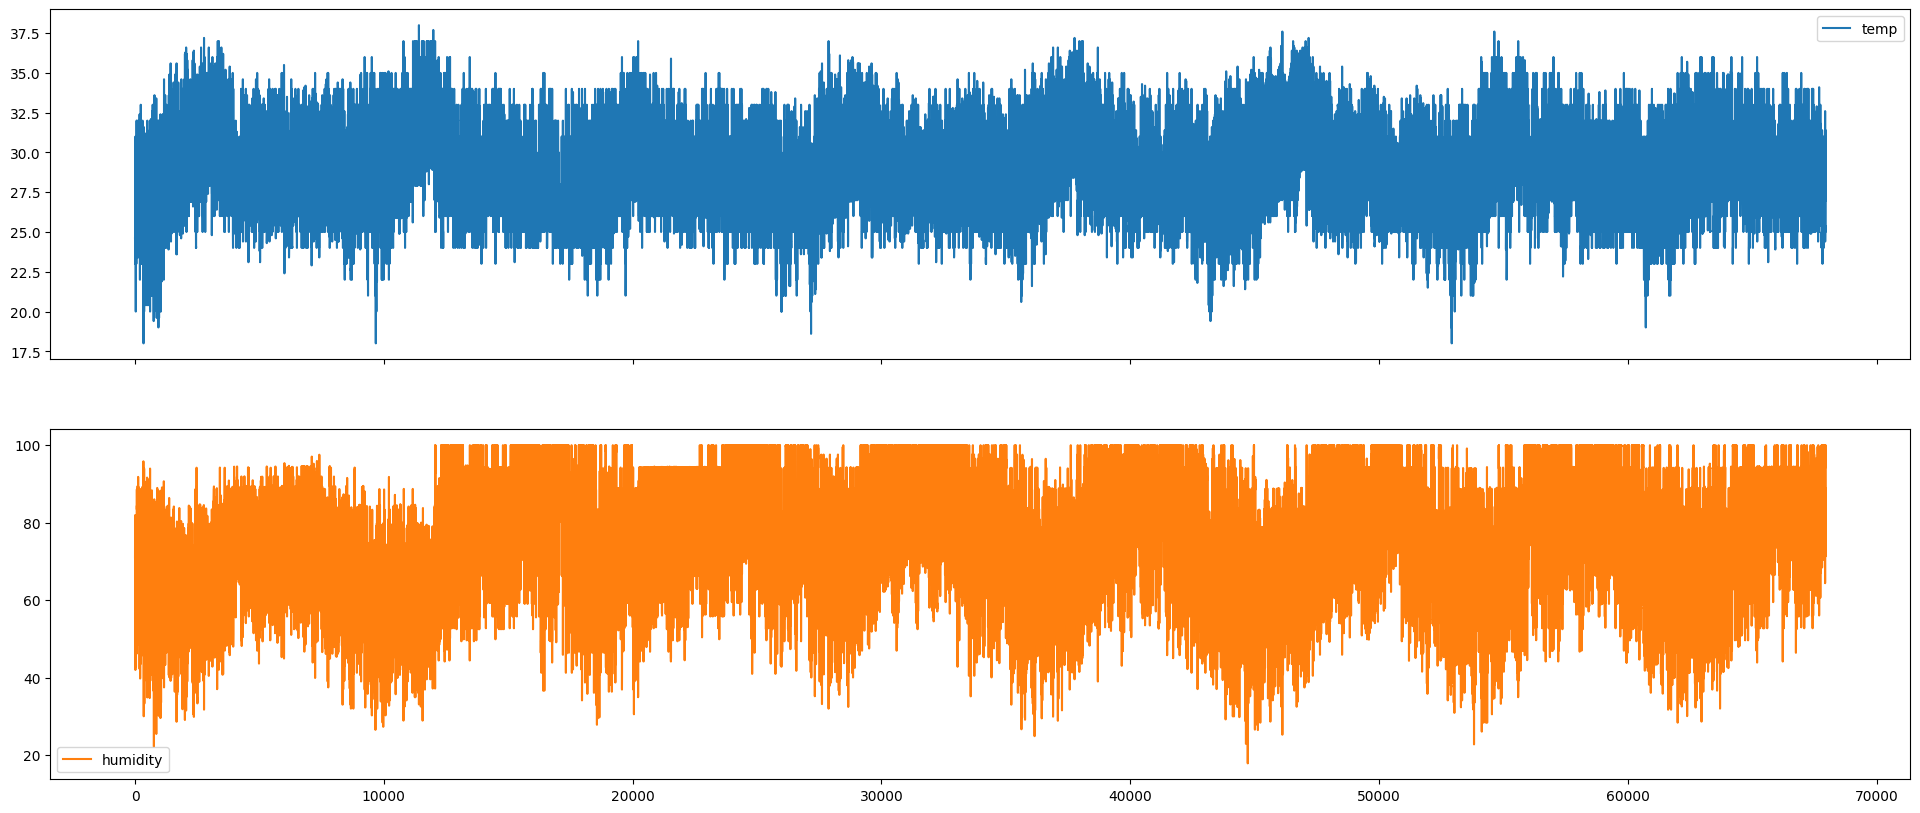

In [7]:
features.plot(subplots=True)

In [8]:
dt_df = df['datetime']

date_list = []
time_list = []
month_list = []

In [9]:
for item in dt_df.values:
    date, time_data = item.split('T')

    time_list.append(int(time_data.split(":")[0]))

    year,month,day = date.split('-')
    month_list.append(int(month))
    date_list.append(int(day))

In [10]:
new_datetime_df = pd.DataFrame({"hour":time_list, "month":month_list, "date":date_list})
new_datetime_df = new_datetime_df.join(features)
new_datetime_df

,hour,month,date,temp,humidity
0,0,1,1,24.6,71.06
1,1,1,1,24.5,77.06
2,2,1,1,24.0,78.35
3,3,1,1,24.0,78.35
4,4,1,1,24.0,81.94
...,...,...,...,...,...
67963,19,10,2,27.0,88.84
67964,20,10,2,27.6,85.80
67965,21,10,2,27.6,85.80
67966,22,10,2,27.0,88.84


In [11]:
TRAIN_SPLIT = 50000

In [12]:
features = new_datetime_df

In [13]:
from matplotlib.pyplot import axis

dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [24]:
features.values[8:12]

array([[ 8.  ,  1.  ,  1.  , 24.4 , 63.36],
       [ 9.  ,  1.  ,  1.  , 26.4 , 59.93],
       [10.  ,  1.  ,  1.  , 28.3 , 50.96],
       [11.  ,  1.  ,  1.  , 29.  , 48.35]])

In [14]:
data_mean[:3] = 0
data_std[:3] = 1

In [15]:
print('DATA MEANS: ', data_mean)
print('DATA STD: ', data_std)

DATA MEANS:  [ 0.         0.         0.        28.425472  75.6995066]
DATA STD:  [ 1.          1.          1.          2.97181957 16.24350521]


In [16]:
dataset = (dataset - data_mean)/data_std

In [17]:
dataset

array([[ 0.        ,  1.        ,  1.        , -1.28724908, -0.28562226],
       [ 1.        ,  1.        ,  1.        , -1.32089849,  0.08375615],
       [ 2.        ,  1.        ,  1.        , -1.48914559,  0.1631725 ],
       ...,
       [21.        , 10.        ,  2.        , -0.27776653,  0.62181735],
       [22.        , 10.        ,  2.        , -0.47966304,  0.80896908],
       [23.        , 10.        ,  2.        , -0.47966304,  0.80896908]])

In [18]:
def get_timeseries_data(dataset, target, start_idx, end_idx, history_size, target_size, step):
    data = list()
    labels = list()

    start_index = start_idx + history_size

    if end_idx is None:
        end_index = len(dataset) - target_size
    else: end_index = end_idx

    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        
        data.append(dataset[indices])
        labels.append(target[i+1: i+ target_size+1][:,3:]) #[:,-3:] for new_df_with_datime

    return np.array(data), np.array(labels)


In [19]:
batch_size = 256

In [20]:
x_train_timeseries, y_train_timeseries = get_timeseries_data(dataset=dataset, target=dataset, start_idx=0, end_idx= TRAIN_SPLIT, history_size=8, target_size=4, step=1)

x_val_timeseries, y_val_timeseries = get_timeseries_data(dataset=dataset, target=dataset, start_idx=TRAIN_SPLIT, end_idx=None, history_size=8, target_size=4, step=1)

In [21]:
x_train_timeseries[0]

array([[ 0.        ,  1.        ,  1.        , -1.28724908, -0.28562226],
       [ 1.        ,  1.        ,  1.        , -1.32089849,  0.08375615],
       [ 2.        ,  1.        ,  1.        , -1.48914559,  0.1631725 ],
       [ 3.        ,  1.        ,  1.        , -1.48914559,  0.1631725 ],
       [ 4.        ,  1.        ,  1.        , -1.48914559,  0.38418391],
       [ 5.        ,  1.        ,  1.        , -1.48914559,  0.04312452],
       [ 6.        ,  1.        ,  1.        , -1.82563977, -0.2523782 ],
       [ 7.        ,  1.        ,  1.        , -1.79199035, -0.35211037]])

In [23]:
y_train_timeseries[0]

array([[-0.68155955, -0.97081919],
       [-0.0422206 , -1.5230399 ],
       [ 0.19332533, -1.68371951],
       [ 0.327923  , -1.75267014]])

In [21]:
print('WINDOWS size: ', x_train_timeseries[0].shape)
print('TARGET size: ', y_train_timeseries[0].shape)

WINDOWS size:  (8, 5)
TARGET size:  (4, 2)


In [22]:
train_data = tf.data.Dataset.from_tensor_slices((x_train_timeseries, y_train_timeseries))
train_data = train_data.cache().shuffle(10000).batch(batch_size).repeat()


val_data = tf.data.Dataset.from_tensor_slices((x_val_timeseries, y_val_timeseries))
val_data = val_data.cache().batch(batch_size).repeat()

In [23]:
from tensorflow.keras import layers as l

# Custom Model

In [24]:
timeseries_model_input = l.Input(shape=x_train_timeseries[0].shape)

model = l.Conv1D(8, kernel_size=3, padding='SAME', activation='relu')(timeseries_model_input)
model = l.SeparableConv1D(8, kernel_size=3, padding='SAME', activation='relu')(model)

model = l.Conv1D(12, kernel_size=3, strides=2, padding='SAME', activation='relu')(model)
model = l.SeparableConv1D(12, kernel_size=3, padding='SAME', activation='relu')(model)
model = l.SeparableConv1D(16, kernel_size=3, padding='SAME', activation='relu')(model)

model = l.Dropout(0.3)(model)

timeseries_model_output = l.Dense(y_train_timeseries.shape[-1])(model)

In [25]:
from tensorflow.keras.models import Model

timeseries_model = Model(inputs= timeseries_model_input, outputs= timeseries_model_output)
timeseries_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8, 5)]            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 8, 8)              128       
_________________________________________________________________
separable_conv1d (SeparableC (None, 8, 8)              96        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4, 12)             300       
_________________________________________________________________
separable_conv1d_1 (Separabl (None, 4, 12)             192       
_________________________________________________________________
separable_conv1d_2 (Separabl (None, 4, 16)             244       
_________________________________________________________________
dropout (Dropout)            (None, 4, 16)             0     

In [26]:
from tensorflow.keras import optimizers as opt
from tensorflow.keras.callbacks import EarlyStopping

timeseries_model.compile(loss='mse', metrics=['mae'], optimizer=opt.Adam())

es = [EarlyStopping(patience=2, monitor='val_loss')]

In [27]:
timeseries_his = timeseries_model.fit(train_data, epochs=30, validation_data=val_data, steps_per_epoch=12000, validation_steps=8000, callbacks=es)

Epoch 1/30
12000/12000 [==============================] - 81s 7ms/step - loss: 0.2692 - mae: 0.3925 - val_loss: 0.2006 - val_mae: 0.3313
Epoch 2/30
12000/12000 [==============================] - 76s 6ms/step - loss: 0.2351 - mae: 0.3643 - val_loss: 0.1927 - val_mae: 0.3194
Epoch 3/30
12000/12000 [==============================] - 76s 6ms/step - loss: 0.2313 - mae: 0.3602 - val_loss: 0.1977 - val_mae: 0.3261
Epoch 4/30
12000/12000 [==============================] - 75s 6ms/step - loss: 0.2300 - mae: 0.3587 - val_loss: 0.1919 - val_mae: 0.3185
Epoch 5/30
12000/12000 [==============================] - 79s 7ms/step - loss: 0.2291 - mae: 0.3578 - val_loss: 0.1993 - val_mae: 0.3285
Epoch 6/30
12000/12000 [==============================] - 76s 6ms/step - loss: 0.2283 - mae: 0.3570 - val_loss: 0.1904 - val_mae: 0.3173
Epoch 7/30
12000/12000 [==============================] - 74s 6ms/step - loss: 0.2276 - mae: 0.3564 - val_loss: 0.1911 - val_mae: 0.3184
Epoch 8/30
12000/12000 [=================

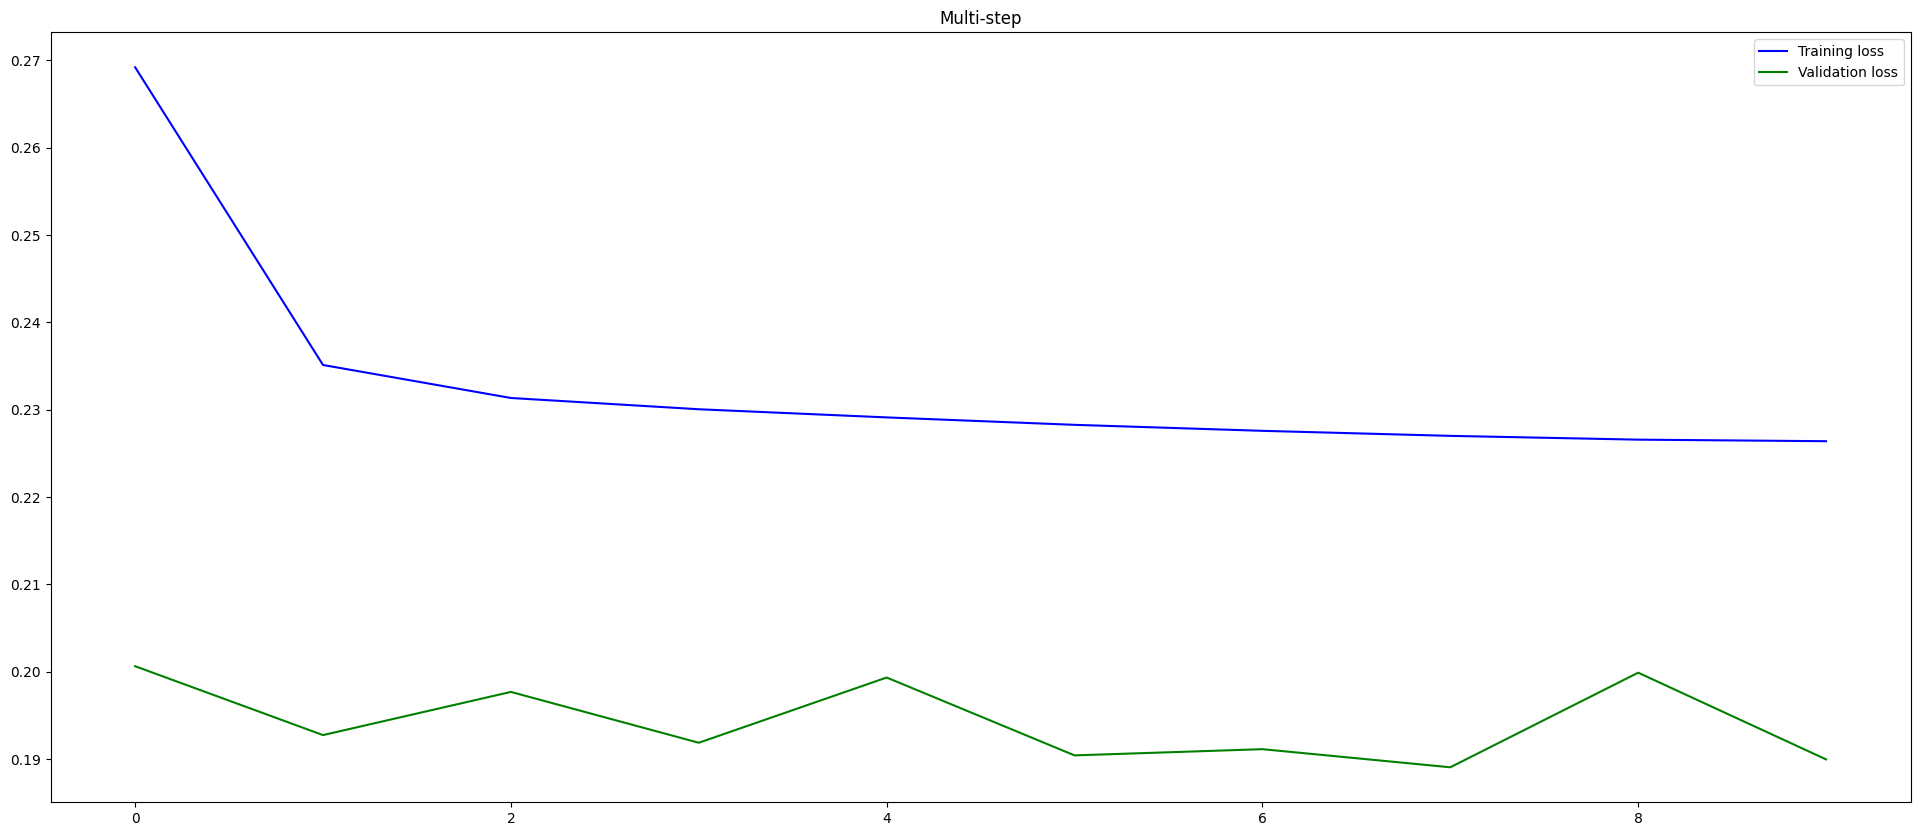

In [28]:
plot_train_history(timeseries_his, 'Multi-step')

<Figure size 1200x600 with 0 Axes>

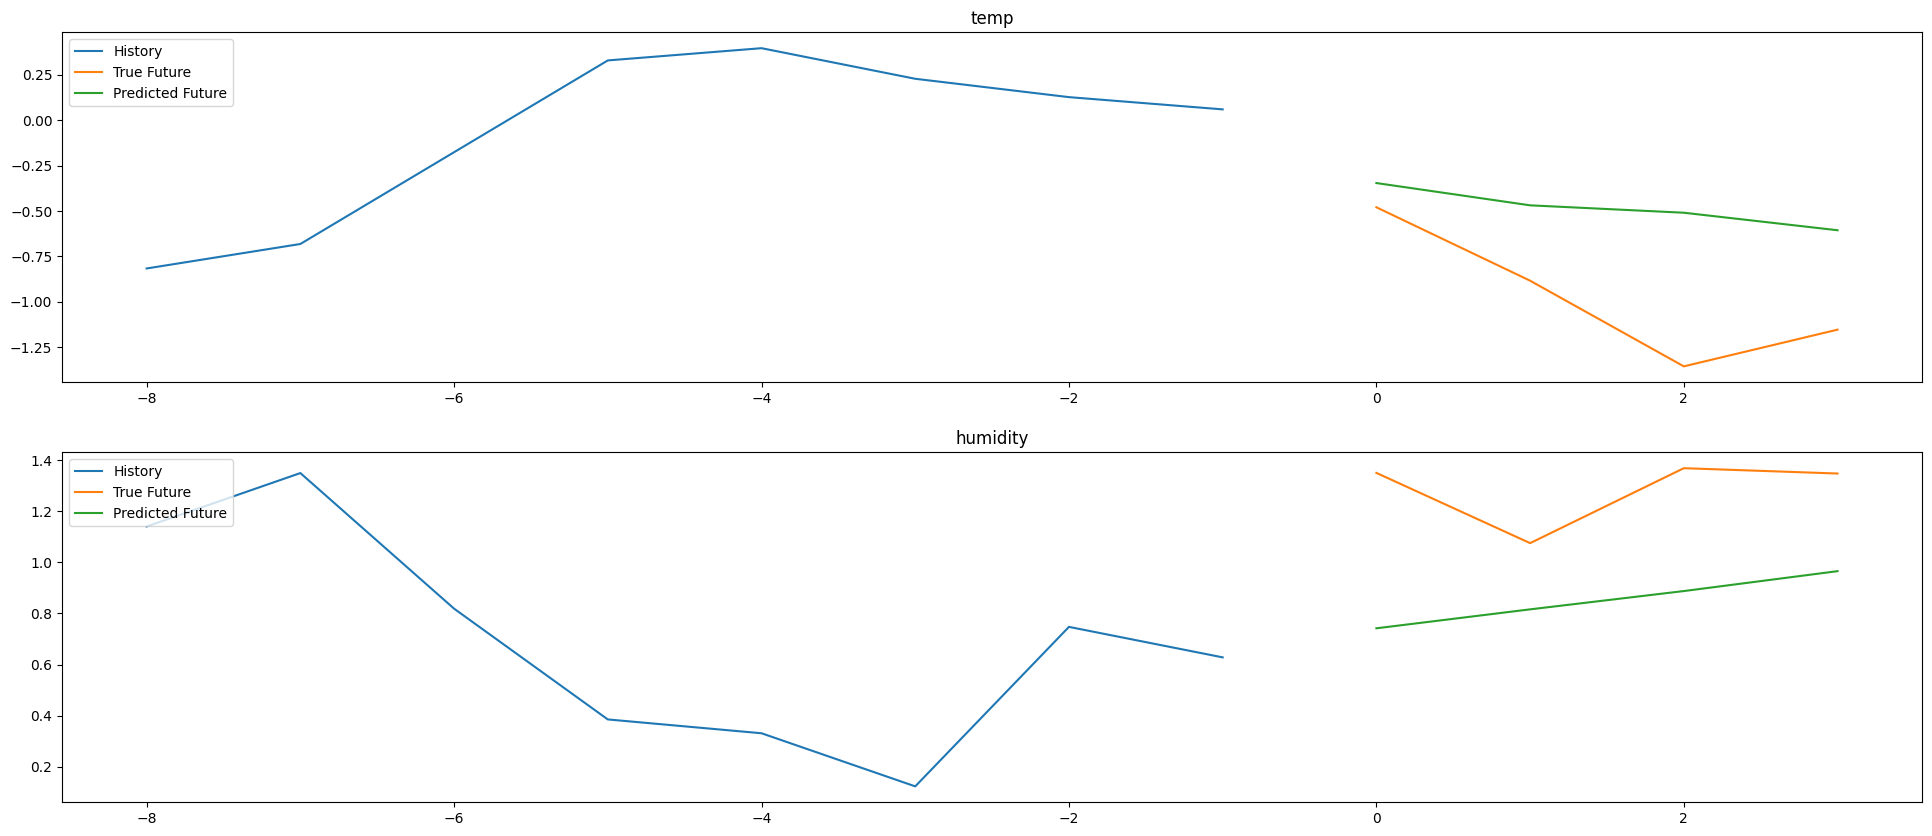

<Figure size 1200x600 with 0 Axes>

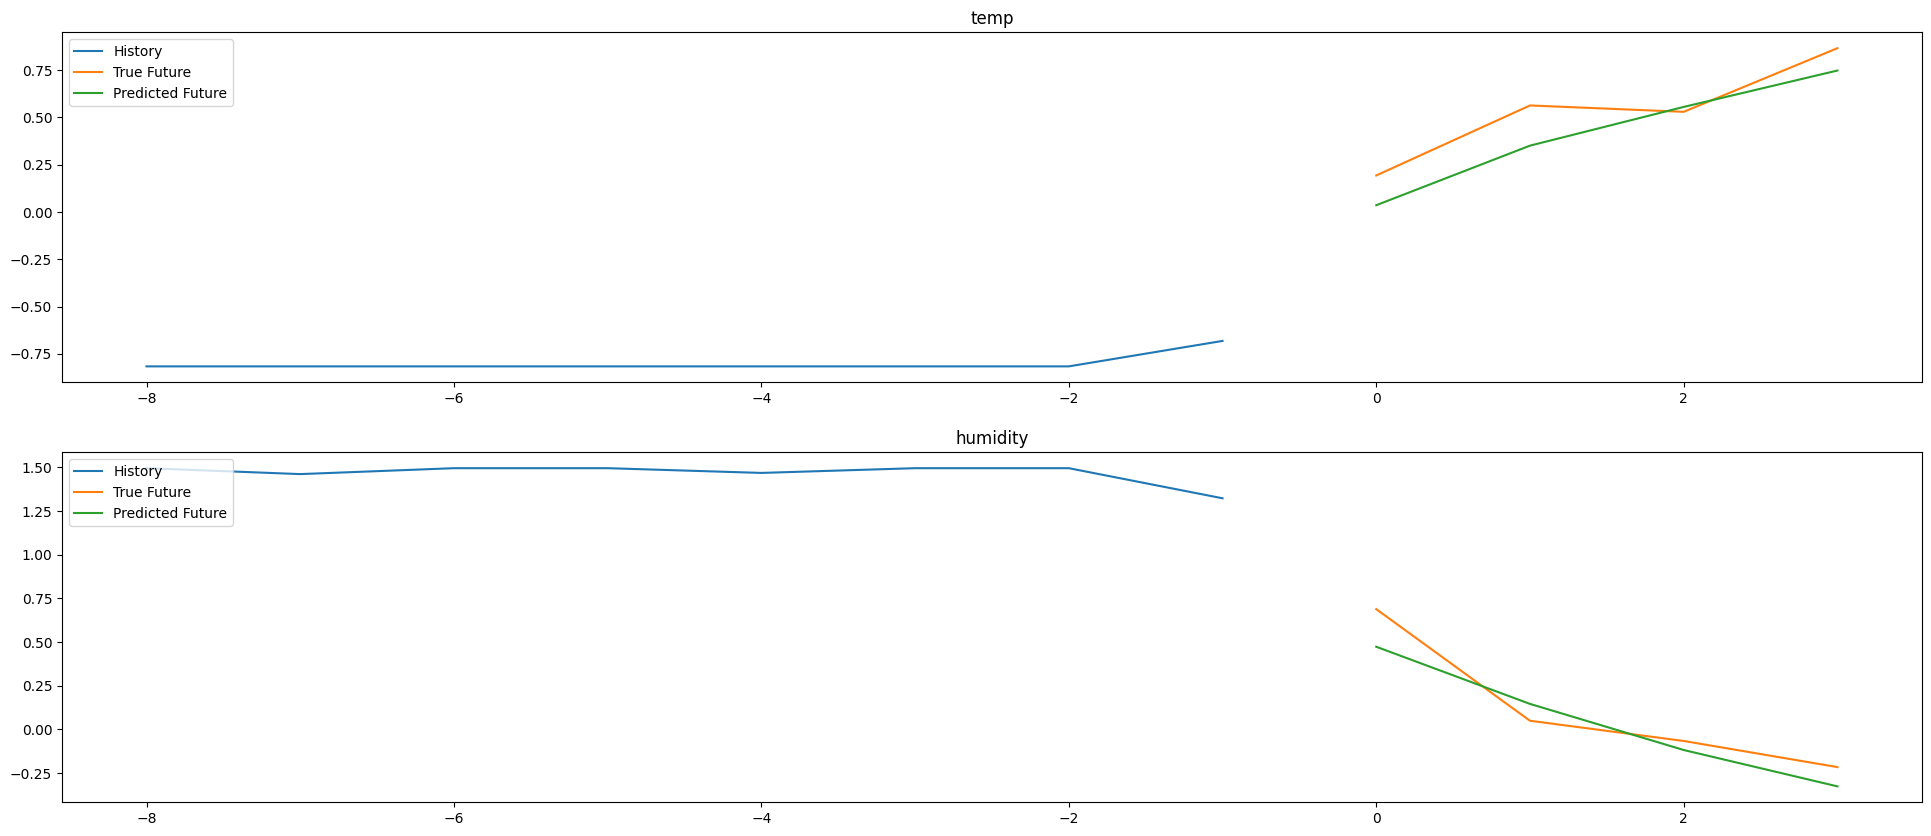

<Figure size 1200x600 with 0 Axes>

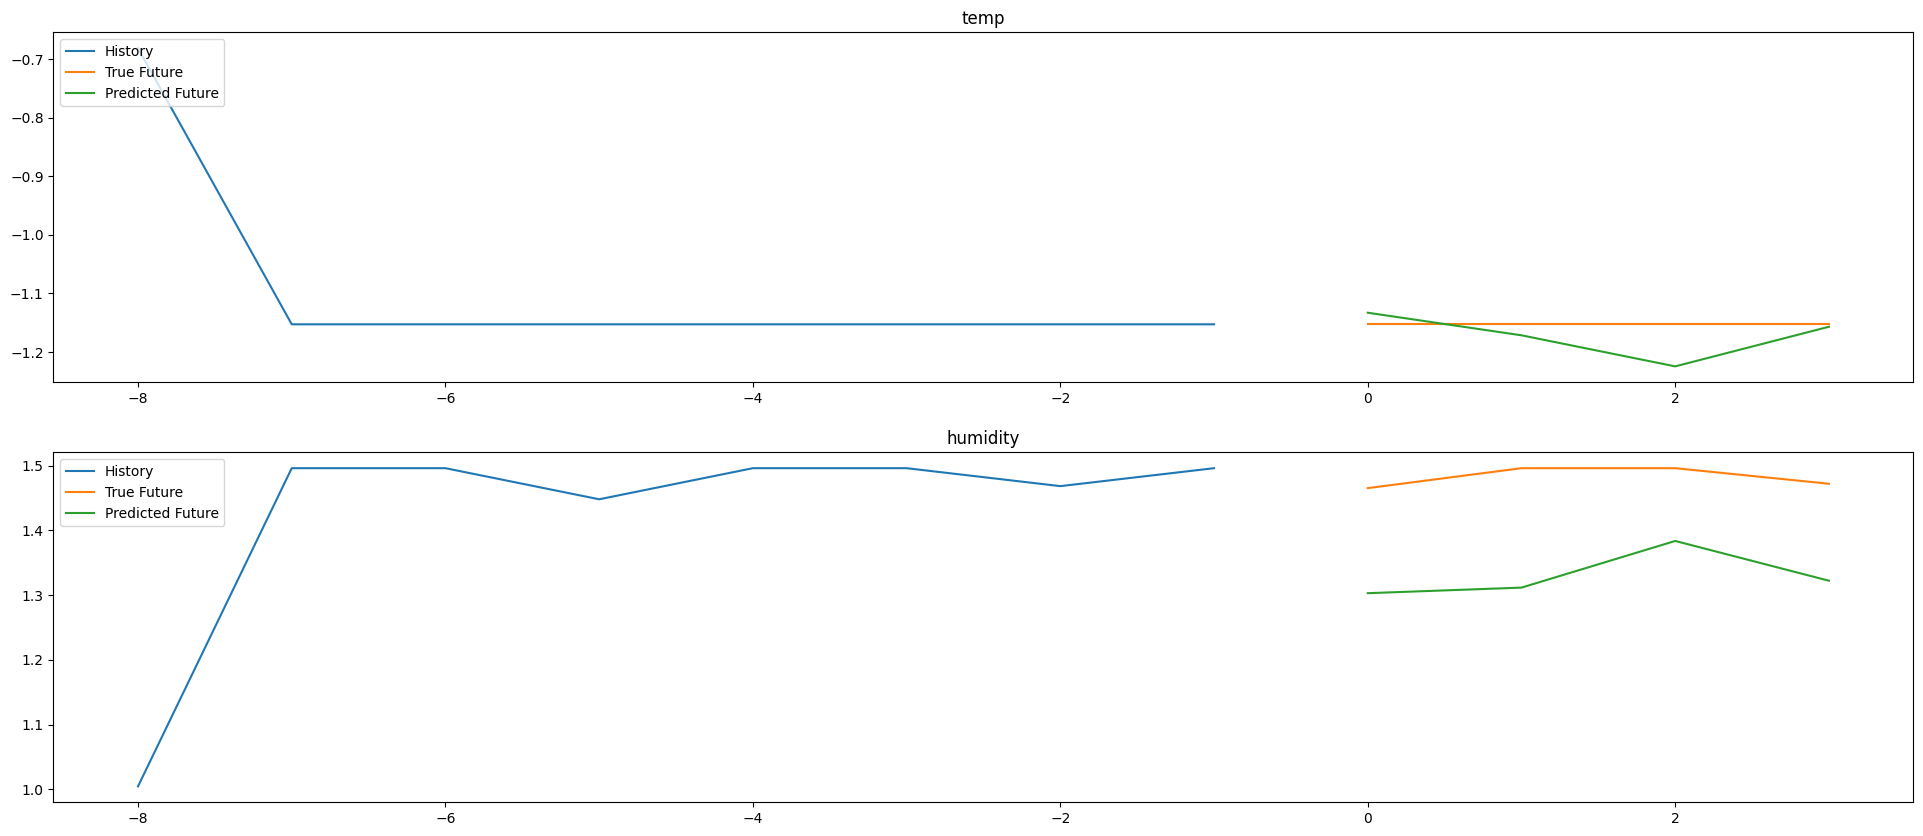

<Figure size 1200x600 with 0 Axes>

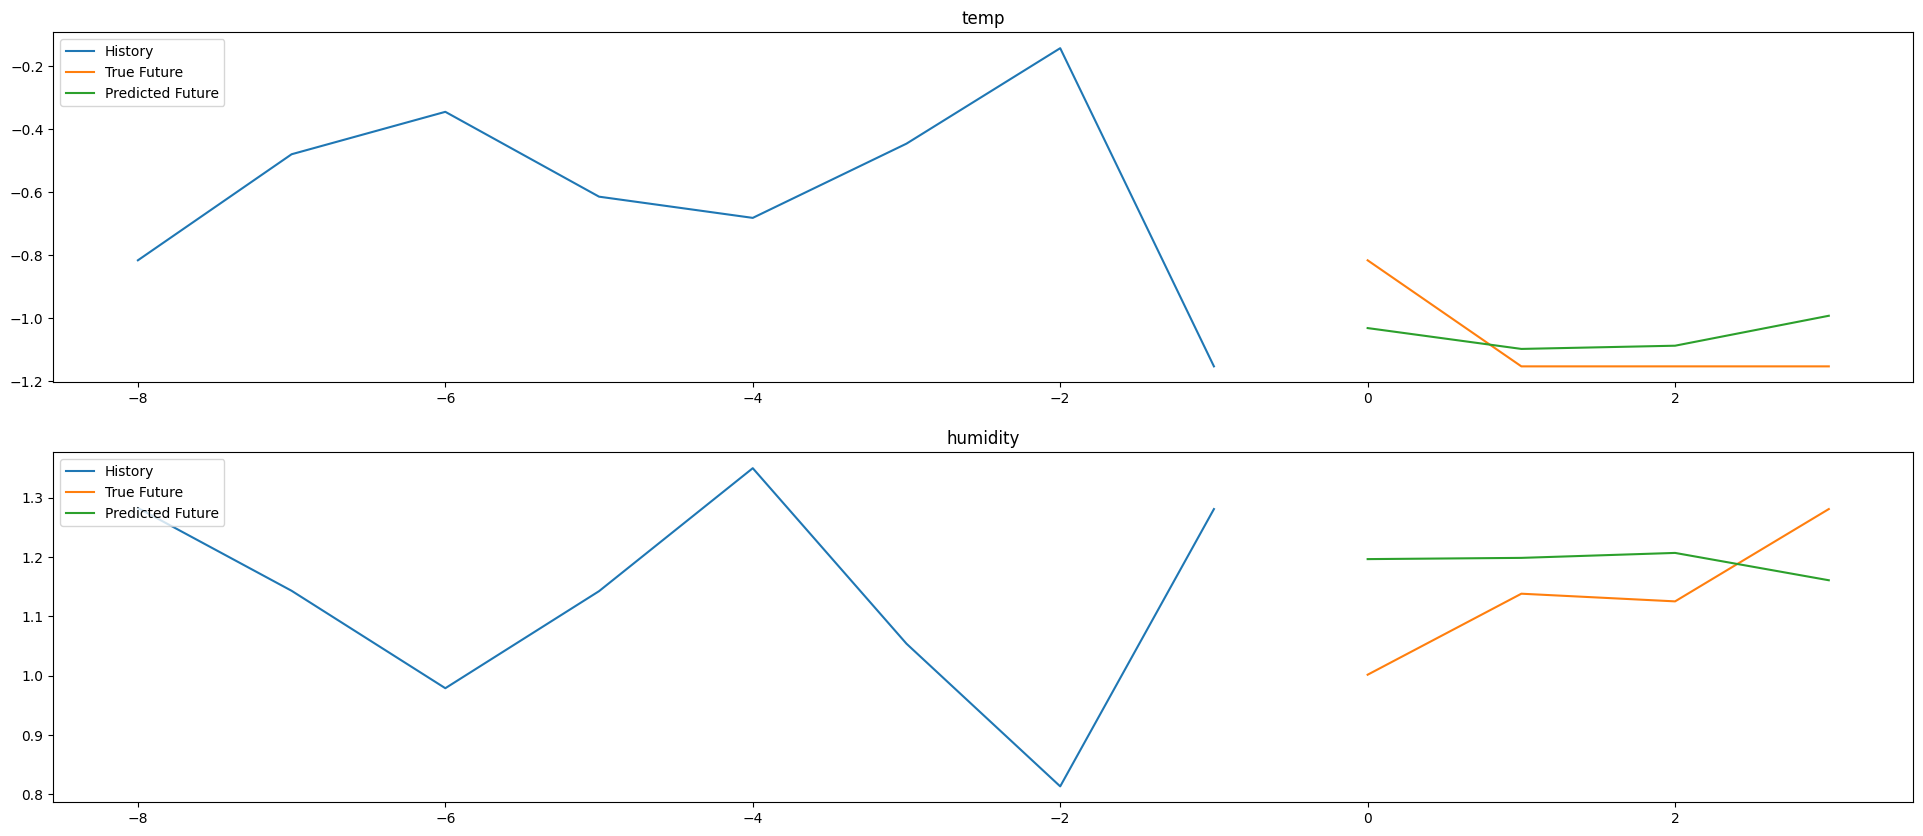

<Figure size 1200x600 with 0 Axes>

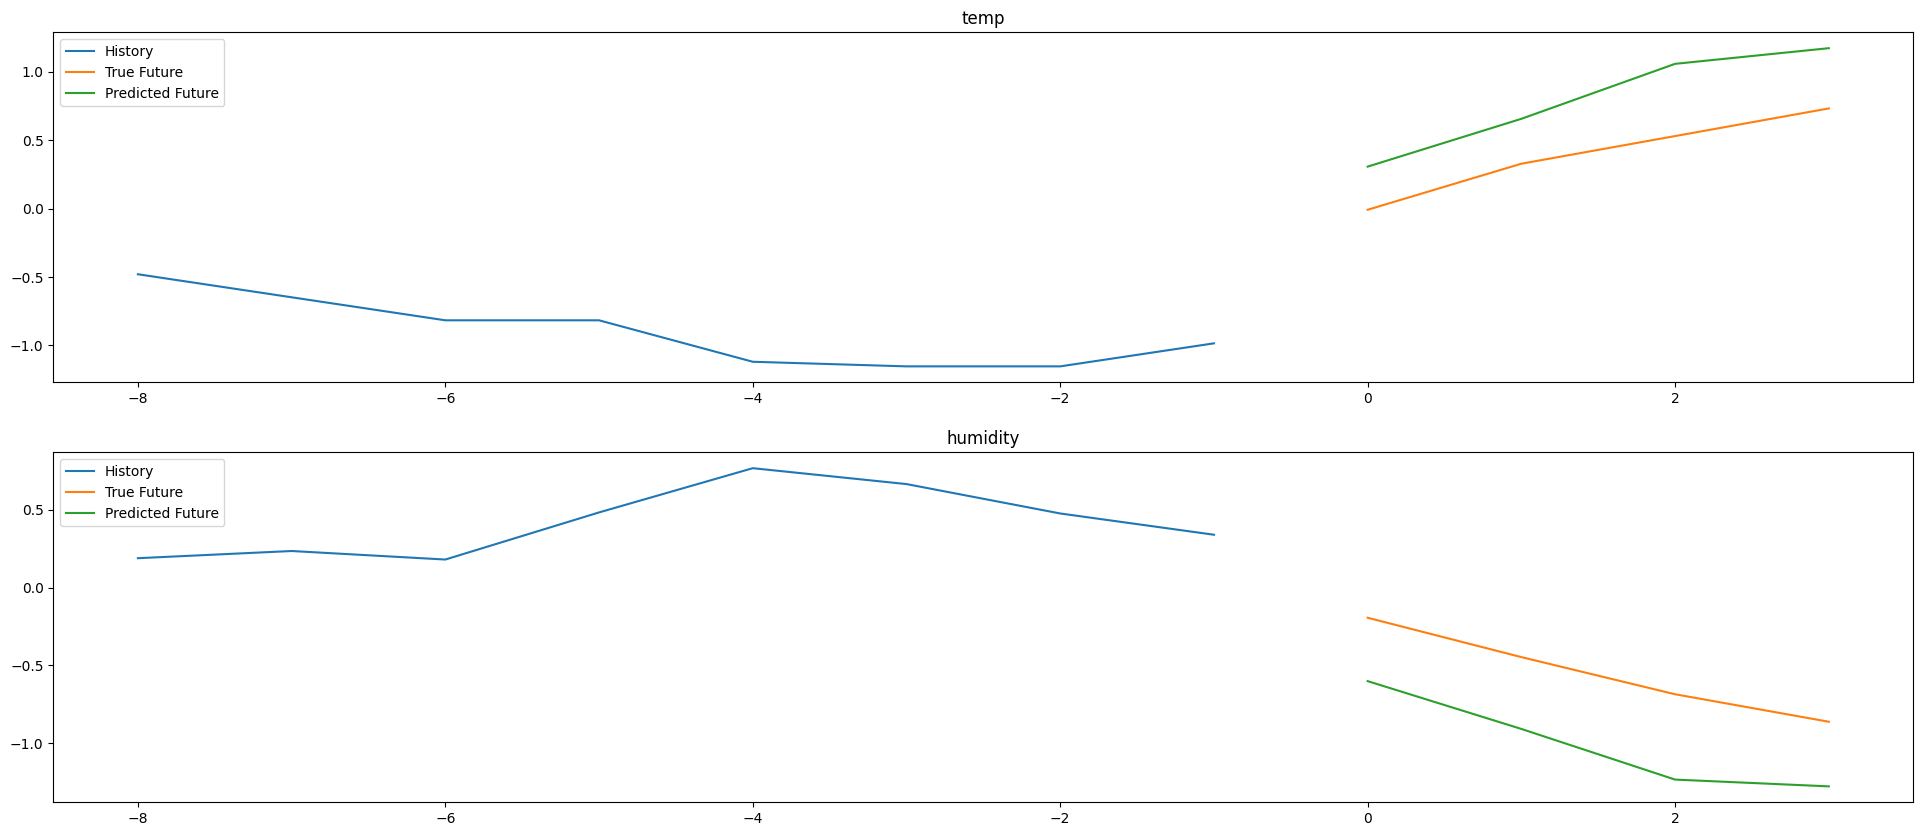

In [29]:
for x, y in val_data.take(5):
    multi_step_plot(x[0], y[0], timeseries_model.predict(x)[0], step=1, df_columns= features.columns)

In [30]:
class representive_dataset:
    def __init__(self, data_list:np.array, batch_size=64):
        self.data = data_list.astype('float32')
        self.batch = batch_size

        self.dataset = tf.data.Dataset.from_tensor_slices(self.data).batch(1)

    def __call__(self):
        for data in self.dataset.take(self.batch):
            yield [data]

In [31]:
gen = representive_dataset(x_train_timeseries)

In [32]:
converter = tf.lite.TFLiteConverter.from_keras_model(timeseries_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.representative_dataset = gen
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()

# Save the model.
with open('model_INT8.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\nguye\AppData\Local\Temp\tmp7d292yho\assets


# INFERENCE TFLITE PART

In [33]:
from tensorflow.lite.python.interpreter import Interpreter

interpreter = Interpreter('model_INT8.tflite')
interpreter.allocate_tensors()
interpreter.invoke()

In [34]:
input_details = interpreter.get_input_details()
print(input_details)

output_details = interpreter.get_output_details()
print(output_details)

[{'name': 'input_1', 'index': 0, 'shape': array([1, 8, 5]), 'shape_signature': array([-1,  8,  5]), 'dtype': <class 'numpy.int8'>, 'quantization': (0.10131420940160751, -100), 'quantization_parameters': {'scales': array([0.10131421], dtype=float32), 'zero_points': array([-100]), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'Identity', 'index': 55, 'shape': array([1, 4, 2]), 'shape_signature': array([-1, -1,  2]), 'dtype': <class 'numpy.int8'>, 'quantization': (0.015586410649120808, 49), 'quantization_parameters': {'scales': array([0.01558641], dtype=float32), 'zero_points': array([49]), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [35]:
def return_original_data(mean,std, output_tensor):
    assert len(output_tensor.shape) == 3, "You must be feed output_tensor as output from interpreter."

    ret_arr = []

    output_from_interpreter = output_tensor[0]
    for value in output_from_interpreter:
        temp = value[0]*std[0] + mean[0]
        humi = value[1]*std[1] + mean[1]

        ret_arr.append(np.array([temp,humi]))

    return np.array(ret_arr)

In [36]:
data_mean_ds = data_mean[3:]
data_std_ds = data_std[3:]

for x, y in val_data.take(1):
    ### Enable numpy behavior 
    from tensorflow.python.ops.numpy_ops import np_config

    np_config.enable_numpy_behavior()
    ### End of Enable numpy behavior 

    one_value_to_test = x[0].astype('float32')
    one_value_to_test = np.expand_dims(one_value_to_test, axis=0)

    interpreter.set_tensor(input_details[0]['index'], one_value_to_test)
    interpreter.invoke()

    output = interpreter.get_tensor(output_details[0]['index'])
    xt = return_original_data(data_mean_ds, data_std_ds, output)
    print(xt)
    print(return_original_data(data_mean_ds, data_std_ds, np.expand_dims(y[0], axis=0)))

ValueError: Cannot set tensor: Got value of type FLOAT32 but expected type INT8 for input 0, name: input_1 